In [21]:
# enable auto‑reload so edits in src/ propagate immediately
%load_ext autoreload
%autoreload 2

# now import everything in one line:
from openiex import (
    SystemConfig, Ion, Protein, Inert, ExchangeSystem,
    Method, validate_method,
    initialize_state, load_state, SimulationTracker,
    method_duration, run_simulation, resume_simulation,
    save_simulation, load_simulation, plot_single_species, plot_chromatogram, plot_column_snapshot,
    SimulationResult
)
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
"""
Define all species in the system. Default unit is M. 
"""


ions = {
    "Cl-": Ion(
        "Cl-",
        D=1e-10, # [m^2/s], Effective axial dispersion coefficient
        mol_cond=76.3, # [S·cm²/mol]
    ),
    "Ac-": Ion(
        "Ac-",
        D=1e-10, # [m^2/s], Effective axial dispersion coefficient
        mol_cond=40.9, # [S·cm²/mol]
    ),
}

proteins = {
    "em": Protein(
        "em", # empty AAV capsid
        D=5e-12, # [m^2/s], Effective axial dispersion coefficient
        sigma=1e5, # Back-calculated from max possible binding of 1E15 cp/mL-resin
        nu=7, # Unrealistically small, but gives nice cooperativity without underflow
        unit="particles/mL",
        ext_coeff_260=3.72e6,
        ext_coeff_280=6.61e6,
        K_d = 1, # Full pore accessibility
    ),
        "pa": Protein(
        "pa", # partially full AAV capsid
        D=5e-12, # [m^2/s], Effective axial dispersion coefficient
        sigma=1e5, # Back-calculated from max possible binding of 1E15 cp/mL-resin
        nu=9, # Unrealistically small, but gives nice cooperativity without underflow
        unit="particles/mL",
        ext_coeff_260=1.92e7, # Assuming 2.35 kb, half genome
        ext_coeff_280=1.51e7, # Assuming 2.35 kb, half genome
        K_d = 1, # Full pore accessibility
    ),
    "fu": Protein(
        "fu", # full AAV capsid
        D=5e-12, # [m^2/s], Effective axial dispersion coefficient
        sigma=1e5, # Back-calculated from max possible binding of 1E15 cp/mL-resin
        nu=10, # Unrealistically small, but gives nice cooperativity without underflow
        unit="particles/mL",
        ext_coeff_260=3.47e7, # Assuming 4.7 kb
        ext_coeff_280=2.35e7, # Assuming 4.7 kb
        K_d = 1, # Full pore accessibility
    ),
}
"""
We can optionally define inert species which might contribute to UV absorbance
or conductivity for more realistic chromatograms.
"""
inert = {
    "Mg2+": Inert(
        "Mg2+",
        D=7.00e-10, # [m^2/s], Effective axial dispersion coefficient
        mol_cond=53.0, # [S·cm²/mol]
    ),
    "Na+": Inert(
        "Na+",
        D=1.33e-9, # [m^2/s], Effective axial dispersion coefficient
        mol_cond=50.1, # [S·cm²/mol]
    ),
}

config = SystemConfig(
    bed_height=0.102, # [m], Tricorn 5/100, 2 mL column
    column_radius=0.0025, # [m], Tricorn 5/100, 2 mL column
    Lambda=0.165, # ionic capacity [mol/L resin], from Cytiva Capto™ Q ImpRes spec. sheet
    epsilon_i=0.35, # [], Interstitial void, estimate
    epsilon_p=0.40, # [], Intraparticle void, estimate
    Nz=20 # Start with 10 for course fitting
)

system = ExchangeSystem(ions, proteins, inert, config)
species_list = list(system.species.keys())
system.set_equilibrium("Cl-", "Ac-", ln_K_eq_val=0, ln_k_ads_val=5)
system.set_equilibrium("em", "Cl-", ln_K_eq_val=7.1, ln_k_ads_val=14)
system.set_equilibrium("em", "Ac-", ln_K_eq_val=-4.0, ln_k_ads_val=14)
system.set_equilibrium("pa", "Cl-", ln_K_eq_val=9.7, ln_k_ads_val=19)
system.set_equilibrium("pa", "Ac-", ln_K_eq_val=-4.6, ln_k_ads_val=19)
system.set_equilibrium("fu", "Cl-", ln_K_eq_val=12.4, ln_k_ads_val=22)
system.set_equilibrium("fu", "Ac-", ln_K_eq_val=-3.5, ln_k_ads_val=22)
system.check_equilibria()

All required equilibria are defined.


In [38]:
buffers = {
    # 1e12 cp/mL {E: 40%, P: 10%, F: 50%}, 2 mM MgCl2
    "Load": {"Cl-": 0.004, "Ac-": 0.0, "em": 4e11, "pa": 1e11, "fu": 5e11, "Mg2+": 0.002, "Na+": 0}, 
    "A": {"Cl-": 0.004, "Ac-": 0.0, "em": 0.0, "pa": 0, "fu": 0.0, "Mg2+": 0.002, "Na+": 0},
    "B": {"Cl-": 0.004, "Ac-": 0.25, "em": 0.0, "pa": 0, "fu": 0.0, "Mg2+": 0.002, "Na+": 0.25},
}

# CV = total column volume with no interstitial void correction
blocks = [
    {"buffer_A": "Load", "buffer_B": "B", "start_B": 0.0, "end_B": 0.0, "duration_CV": 2, "flow_rate_mL_min": 2.0},
    {"buffer_A":"A","buffer_B":"B",
     "start_B":0.0, "end_B":0.0,
     "duration_CV": 5,
     "flow_rate_mL_min": 2
    },
]

method = Method(buffers, blocks)
validate_method(method, system)

In [39]:
# debug y0
init = {"Cl-": {"C":0.004, "Q":system.config.Lambda},
        "Mg2+": {"C":0.002}}
y0 = initialize_state(init, system)

Nz        = system.config.Nz
species   = list(system.species.keys())
n_species = len(species)

print("Species:", species)
print("Expected y0 length:", 2 * Nz * n_species, "  Actual:", y0.size)

# reshape and peek first slice
y0r = y0.reshape(2, n_species, Nz)
print("C (first cell):", {s:y0r[0,i,0] for i,s in enumerate(species)})
print("Q (first cell):", {s:y0r[1,i,0] for i,s in enumerate(species)})

Species: ['Cl-', 'Ac-', 'em', 'pa', 'fu', 'Mg2+', 'Na+']
Expected y0 length: 280   Actual: 280
C (first cell): {'Cl-': np.float64(0.004), 'Ac-': np.float64(0.0), 'em': np.float64(0.0), 'pa': np.float64(0.0), 'fu': np.float64(0.0), 'Mg2+': np.float64(0.002), 'Na+': np.float64(0.0)}
Q (first cell): {'Cl-': np.float64(0.165), 'Ac-': np.float64(0.0), 'em': np.float64(0.0), 'pa': np.float64(0.0), 'fu': np.float64(0.0), 'Mg2+': np.float64(0.0), 'Na+': np.float64(0.0)}


In [46]:
initial_conditions = {
    "Cl-": {"C": 0.004, "Q": system.config.Lambda},
    "Mg2+": {"C": 0.002}
}
y0 = initialize_state(initial_conditions, system)
t_final = method_duration(method, system)
t_eval = np.linspace(0, t_final, 1000)
res: SimulationResult = run_simulation(
    y0, t_eval, method, system, 
    integrator='BDF', 
    rtol=1e-4,
    atol=1e-7,
    max_step=0.02,
    first_step=1e-3,
)

Simulating:   0%|          | 0/420.49661717589834 [00:00<?, ?s/s]

KeyboardInterrupt: 

In [83]:
save_simulation("results/run4", res)

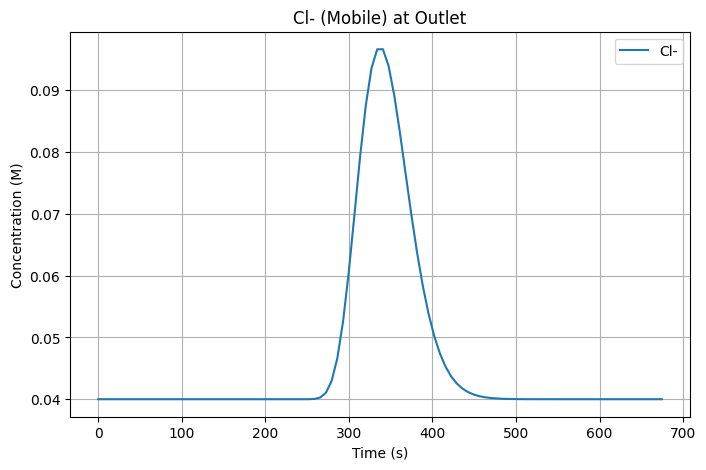

In [7]:
plot_single_species(
    res,
    "Cl-",
    x_axis="time"
)

In [85]:
res_loaded: SimulationResult = load_simulation("results/run4")

In [16]:
plot_column_snapshot(res, 'em', bound=False)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Time (s)', max=674.53956773…

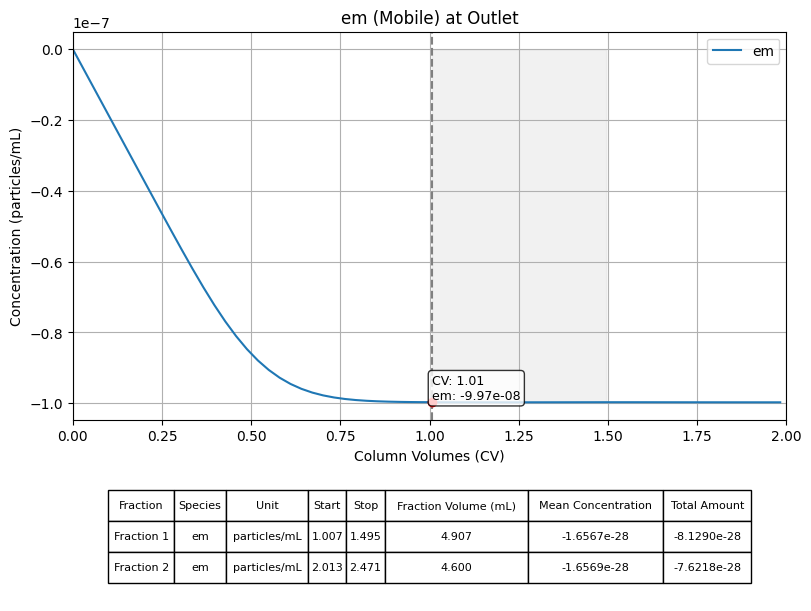

In [17]:
plot_single_species(
    res,
    "em",
    x_axis='CV',
    x_window=(0, 2),
    data_point=1,
    fractions=[(1,1.5), (2,2.5)],
)

In [98]:
# 2) Resume with a new method2
t_final = method_duration(method, system)
t_eval = np.linspace(0, t_final, 100)
res: SimulationResult = resume_simulation(
    res_loaded, t_eval, method, system,
    t_start = 500,        
    integrator='BDF',
    rtol=1e-3,
    atol=1e-5,
    max_step=0.1
)


Simulating:   0%|          | 0/1174.5395677373806 [00:00<?, ?s/s]

In [100]:
save_simulation("results/run4_extended", res)

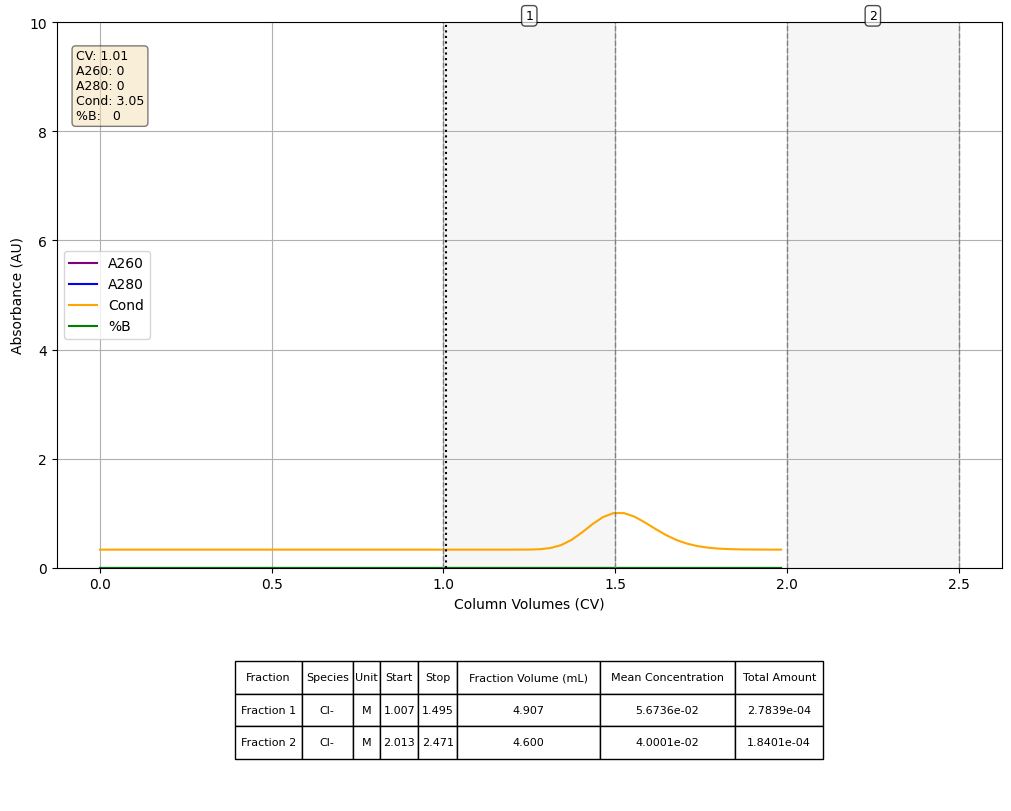

In [44]:
plot_chromatogram(
    res,
    x_axis='CV',
    x_window=(0, 2),
    y_axis='UV',
    y_window=(0,10),
    data_point=1,
    fractions=[(1,1.5), (2,2.5)],
    frac_species=['Cl-']
)